# EES1133 Lab 2b: 30-Layer Grey Atmosphere Model with `climlab`

Adapted from notes by:
[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

In [2]:
#  Load packages that we will need

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import climlab

In this lab and future labs, we will work with `climlab` in order to test different climate modelling concepts using simple radiative equilibrium (RE) and radiative-convective equilibrium (RCE) models. 

____________
<a id='section2'></a>
## I. The observed annual, global mean temperature profile
____________

To start, we want to model the OLR in a column whose temperatures match observations. First, we'll calculate the global, annual mean air temperature from the NCEP Reanalysis data.

In [5]:
# This will try to read the data over the internet.
ncep_filename = 'air.mon.1981-2010.ltm.nc'
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"

#  Open handle to data
ncep_air = xr.open_dataset( ncep_url + ncep_filename, decode_times=False )

In [3]:
#Take global, annual average (because we are on a sphere, we need to weight the data by cos of latitude)
weight = np.cos(np.deg2rad(ncep_air.lat)) / np.cos(np.deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
print(Tglobal)

<xarray.DataArray (level: 17)>
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0


In [4]:
Tglobal.level

<xarray.DataArray 'level' (level: 17)>
array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,  200.,
        150.,  100.,   70.,   50.,   30.,   20.,   10.], dtype=float32)
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
Attributes:
    units:         millibar
    long_name:     Level
    positive:      down
    GRIB_id:       100
    GRIB_name:     hPa
    actual_range:  [1000.   10.]
    axis:          Z

We're going to convert this to degrees Kelvin, using a handy list of pre-defined constants in climlab.constants

In [5]:
climlab.constants.tempCtoK

273.15

In [6]:
#Add this constant to the temperature profile
Tglobal += climlab.constants.tempCtoK
print( Tglobal)

<xarray.DataArray (level: 17)>
array([288.32907, 284.357  , 280.9883 , 273.36993, 266.70166, 258.26114,
       247.57953, 233.7803 , 226.35208, 219.49774, 212.58643, 206.14392,
       207.61707, 211.66336, 217.29642, 221.55605, 229.93001],
      dtype=float32)
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0


In [7]:
Tglobal[0]

<xarray.DataArray ()>
array(288.32907, dtype=float32)
Coordinates:
    level    float32 1000.0

In [8]:
# A handy re-usable routine for making a plot of the temperature profiles
# We will plot temperatures with respect to log(pressure) to get a height-like coordinate

def zstar(lev):
    return -np.log(lev / climlab.constants.ps)

def plot_soundings(result_list, name_list, plot_obs=True, fixed_range=True):
    color_cycle=['r', 'g', 'b', 'y']
    fig, ax = plt.subplots(figsize=(9,9))
    if plot_obs:
        ax.plot(Tglobal, zstar(Tglobal.level), color='k', label='Observed')    
    for i, state in enumerate(result_list):
        Tatm = state['Tatm']
        lev = Tatm.domain.axes['lev'].points
        Ts = state['Ts']
        ax.plot(Tatm, zstar(lev), color=color_cycle[i], label=name_list[i])
        ax.plot(Ts, 0, 'o', markersize=12, color=color_cycle[i])
    #ax.invert_yaxis()
    yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10., 5.])
    ax.set_yticks(-np.log(yticks/1000.))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Temperature (K)', fontsize=14)
    ax.set_ylabel('Pressure (hPa)', fontsize=14)
    ax.grid()
    ax.legend()
    if fixed_range:
        ax.set_xlim([200, 300])
        ax.set_ylim(zstar(np.array([1000., 5.])))
    #ax2 = ax.twinx()
    
    return ax

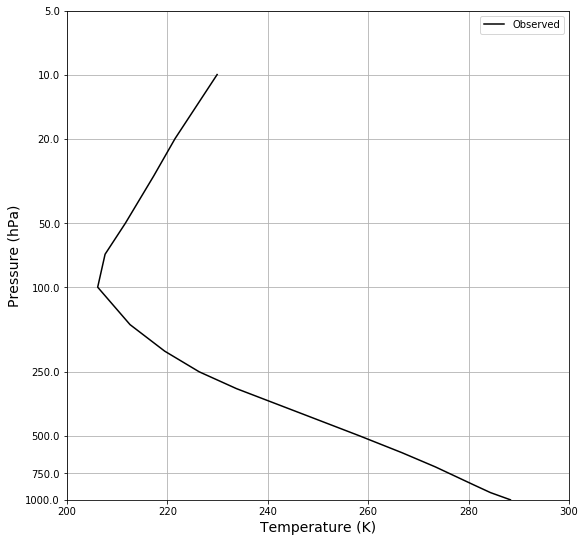

In [9]:
plot_soundings([],[])

____________
<a id='section4'></a>

## II. A 30-layer model using the observed temperatures
____________



We want to create a 30-layer model that is initialized with the observed, globally averaged temperature profile. Let's get started.

In [10]:
#Initialize a grey radiation model with 30 levels (30 levels is the default)
col = climlab.GreyRadiationModel(num_levs=30)
print(col)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [11]:
#print out the levels (these levels are based on pressure)
col.lev

array([ 16.66666667,  50.        ,  83.33333333, 116.66666667,
       150.        , 183.33333333, 216.66666667, 250.        ,
       283.33333333, 316.66666667, 350.        , 383.33333333,
       416.66666667, 450.        , 483.33333333, 516.66666667,
       550.        , 583.33333333, 616.66666667, 650.        ,
       683.33333333, 716.66666667, 750.        , 783.33333333,
       816.66666667, 850.        , 883.33333333, 916.66666667,
       950.        , 983.33333333])

In [12]:
#Interpolate the observed temperatures to 30 evenly spaced pressure levels
lev = col.lev
Tinterp = np.interp(lev, np.flipud(Tglobal.level), np.flipud(Tglobal))
print(Tinterp)
#  Need to 'flipud' because the interpolation routine 
#  needs the pressure data to be in increasing order

[224.34737604 211.66336272 206.96235273 208.29145078 212.5864485
 217.1939926  221.78254026 226.35209151 231.30424019 236.08018424
 240.67992366 245.27966307 249.35980325 252.92034421 256.48088517
 259.66790594 262.4814065  265.29490707 267.81303803 270.03579937
 272.25856072 274.21642867 275.90940323 277.60237779 279.29535236
 280.98832692 282.48551584 283.98270476 285.68102879 287.44639785]


In [13]:
#Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp

In [14]:
col.state

{'Ts': Field([288.32908239]),
 'Tatm': Field([224.34737604, 211.66336272, 206.96235273, 208.29145078,
        212.5864485 , 217.1939926 , 221.78254026, 226.35209151,
        231.30424019, 236.08018424, 240.67992366, 245.27966307,
        249.35980325, 252.92034421, 256.48088517, 259.66790594,
        262.4814065 , 265.29490707, 267.81303803, 270.03579937,
        272.25856072, 274.21642867, 275.90940323, 277.60237779,
        279.29535236, 280.98832692, 282.48551584, 283.98270476,
        285.68102879, 287.44639785])}

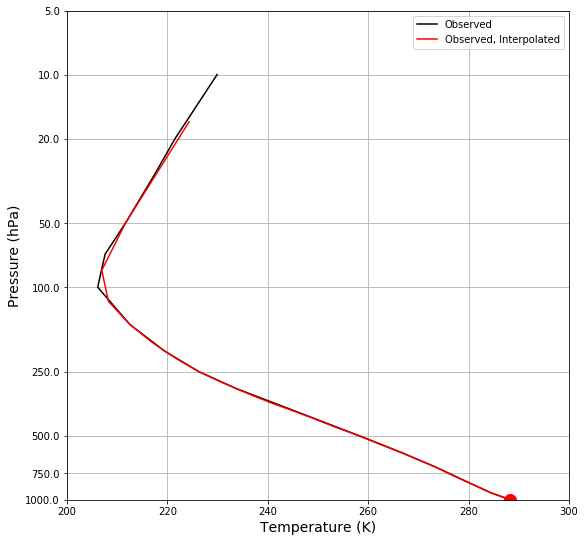

In [15]:
#This should look just like the observations
result_list = [col.state]
name_list = ['Observed, Interpolated']
plot_soundings(result_list, name_list);

### Tune absorptivity to get observed OLR

Now, let's tune the absorptivity to get the observed OLR, so that out interpolated profiles gives us a model result that looks like observations

In [16]:
# Need to tune absorptivity to get OLR = 238.5
epsarray = np.linspace(0.01, 0.1, 100)
OLRarray = np.zeros_like(epsarray)

Text(0,0.5,'OLR')

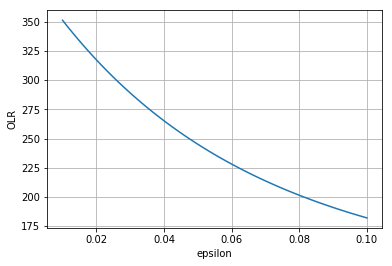

In [17]:
for i in range(epsarray.size):
    col.subprocess['LW'].absorptivity = epsarray[i]
    col.compute_diagnostics()
    OLRarray[i] = col.OLR

plt.plot(epsarray, OLRarray)
plt.grid()
plt.xlabel('epsilon')
plt.ylabel('OLR')

The necessary value seems to lie near 0.055 or so.

We can be more precise with a numerical root-finder.

In [18]:
def OLRanom(eps):
    col.subprocess['LW'].absorptivity = eps
    col.compute_diagnostics()
    return col.OLR - 238.5

In [19]:
# Use numerical root-finding to get the equilibria
from scipy.optimize import brentq
# brentq is a root-finding function
#  Need to give it a function and two end-points
#  It will look for a zero of the function between those end-points
eps = brentq(OLRanom, 0.01, 0.1)
print( eps)

0.05369075475256376


In [20]:
col.subprocess.LW.absorptivity = eps
col.subprocess.LW.absorptivity

Field([0.05369075, 0.05369075, 0.05369075, 0.05369075, 0.05369075,
       0.05369075, 0.05369075, 0.05369075, 0.05369075, 0.05369075,
       0.05369075, 0.05369075, 0.05369075, 0.05369075, 0.05369075,
       0.05369075, 0.05369075, 0.05369075, 0.05369075, 0.05369075,
       0.05369075, 0.05369075, 0.05369075, 0.05369075, 0.05369075,
       0.05369075, 0.05369075, 0.05369075, 0.05369075, 0.05369075])

In [21]:
col.compute_diagnostics()
col.OLR

array([238.5])

____________
<a id='section6'></a>

## III. Radiative equilibrium in the 30-layer model
____________


In [22]:
re = climlab.process_like(col)

In [23]:
#To get to equilibrium, we just time-step the model forward long enough
re.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 0.9993368783782377 years.


In [24]:
# Check for energy balance
print( 'The net downward radiative flux at TOA is %.4f W/m2.' %(re.ASR - re.OLR))

The net downward radiative flux at TOA is -0.0015 W/m2.


In [25]:
re.Ts - np.float(Tglobal[0])

Field([8.00394603])

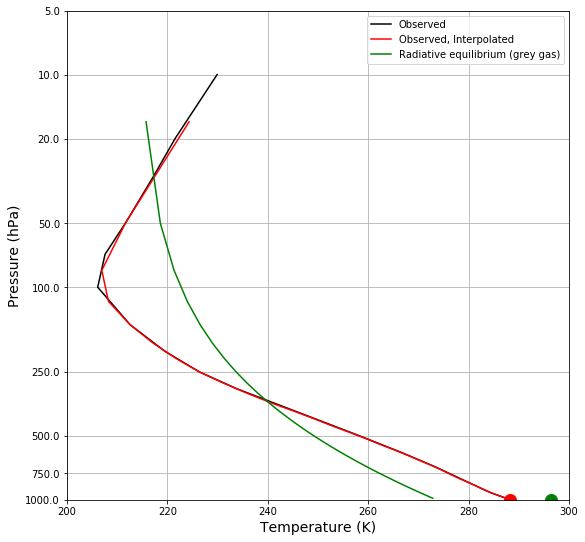

In [26]:
result_list.append(re.state)
name_list.append('Radiative equilibrium (grey gas)')
plot_soundings(result_list, name_list)

Some properties of the **radiative equilibrium** temperature profile:

- The surface is warmer than observed.
- The lower troposphere is colder than observed.
- Very cold air is sitting immediately above the warm surface.
- There is no tropopause, no stratosphere.

____________
<a id='section7'></a>

## IV. Radiative-Convective Equilibrium in the 30-layer model
____________

We recognize that the large drop in temperature just above the surface is unphysical. Parcels of air in direct contact with the ground will be warmed by mechansisms other than radiative transfer.

These warm air parcels will then become buoyant, and will convect upward, mixing their heat content with the environment.

We **parameterize** the statistical effects of this mixing through a **convective adjustment**. 

At each timestep, our model checks for any locations at which the **lapse rate** exceeds some threshold. Unstable layers are removed through an energy-conserving mixing formula.

This process is assumed to be fast relative to radiative heating. In the model, it is instantaneous.

### Add the convective adjustment as an additional subprocess

In [27]:
#Here is the existing model
print(re)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [28]:
#First we make a new clone
rce = climlab.process_like(re)

#Then create a new ConvectiveAdjustment process
conv = climlab.convection.ConvectiveAdjustment(state=rce.state,adj_lapse_rate=6.5)

#And add it to our model
rce.add_subprocess('Convective Adjustment', conv)
print(rce)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



This model is exactly like our previous models, except for one additional subprocess called ``Convective Adjustment``. 

We passed a parameter ``adj_lapse_rate`` (in K / km) that sets the neutrally stable lapse rate -- in this case, 9.8 K / km.

This number is chosed to very loosely represent the net effect of **dry convection**.

In [29]:
#  Run out to equilibrium
rce.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 1.9986737567564754 years.


In [30]:
#  Check for energy balance
rce.ASR - rce.OLR

Field([0.00079763])

In [31]:
moist = rce.Ts

In [33]:
result_list.append(rce.state)
name_list.append('Radiatve-Convective equilibrium (grey gas)')

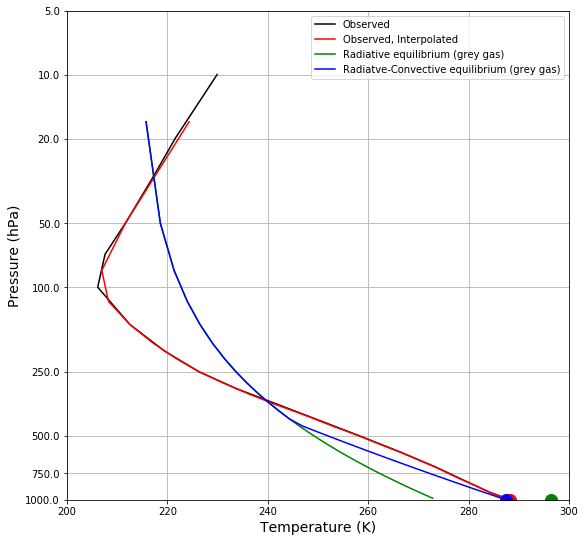

In [34]:
plot_soundings(result_list, name_list)

Introducing convective adjustment into the model cools the surface quite a bit (compared to Radiative Equilibrium, in green here) -- and warms the lower troposphere. It gives us a MUCH better fit to observations.

____________
<a id='section3'></a>
## Questions
____________

1. a. How many pressure levels are there for the observed temperature profile? What is the pressure of the top level and the bottom level?
<p/>
   b. What is the pressure of the top level and bottom level of your 30-layer model? 
<p/>

2. a. How much warmer is your surface temperature after the model reaches radiative equilibrium compared to observed?
<p/>
   b. How does the surface temperature change after the model reaches radiative-convective equilibrium compared to observed?
<p/>

3. Re-run you radiative-convective model with the moist adiabatic lapse rate (6.5 K/km) rather than the dry adiabatic lapse rate. By how much does the surface temperature change compared to the simulation with the dry adiabatic lapse rate?
<p/>

4. Why do the RCE models produce a more realistic temperature profile than the RE model?
<p/>

5. What key upper atmospheric component is missing in our model that prevents our temperature profile from looking realistic? 
<p/>
</p>